In [1]:
# suppres some warnings from mlchemad
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)

# Applicability Domain

Applicability domain is the area of the chemical space where the model is suitable to make predictions. It is important to know the applicability domain of a model to understand when it is extrapolating. Making predictions for compounds outside the applicability domain may lead to unexpectedly unreliable results. There are many ways to define the applicability domain of a model. In this tutorial, we will demonstrate how to use applicability domain calculations are integrated in QSPRpred.

In [2]:
# First create the dataset
import os

from qsprpred.data import QSPRDataset

os.makedirs("../../tutorial_output/data", exist_ok=True)

dataset = QSPRDataset.fromTableFile(
    filename="../../tutorial_data/A2A_LIGANDS.tsv",
    store_dir="../../tutorial_output/data",
    name="ApplicabilityDomainTutorialDataset",
    target_props=[{"name": "pchembl_value_Mean", "task": "REGRESSION"}],
    random_state=42
)

dataset.getDF()

,SMILES,pchembl_value_Mean,Year,QSPRID,pchembl_value_Mean_original
QSPRID,,,,,
ApplicabilityDomainTutorialDataset_0000,Cc1nn(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n2)c(...,8.68,2008.0,ApplicabilityDomainTutorialDataset_0000,8.68
ApplicabilityDomainTutorialDataset_0001,Nc1c(C(=O)Nc2ccc([N+](=O)[O-])cc2)sc2c1cc1CCCC...,4.82,2010.0,ApplicabilityDomainTutorialDataset_0001,4.82
ApplicabilityDomainTutorialDataset_0002,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,5.65,2009.0,ApplicabilityDomainTutorialDataset_0002,5.65
ApplicabilityDomainTutorialDataset_0003,CNC(=O)C12CC1C(n1cnc3c1nc(C#CCCCCC(=O)OC)nc3NC...,5.45,2009.0,ApplicabilityDomainTutorialDataset_0003,5.45
ApplicabilityDomainTutorialDataset_0004,CCCn1c(=O)c2c(nc3cc(OC)ccn32)n(CCCNC(=O)c2ccc(...,5.20,2019.0,ApplicabilityDomainTutorialDataset_0004,5.20
...,...,...,...,...,...
ApplicabilityDomainTutorialDataset_4077,CNc1ncc(C(=O)NCc2ccc(OC)cc2)c2nc(-c3ccco3)nn12,7.09,2018.0,ApplicabilityDomainTutorialDataset_4077,7.09
ApplicabilityDomainTutorialDataset_4078,Nc1nc(-c2ccco2)c2ncn(C(=O)NCCc3ccccc3)c2n1,8.22,2008.0,ApplicabilityDomainTutorialDataset_4078,8.22
ApplicabilityDomainTutorialDataset_4079,Nc1nc(Nc2ccc(F)cc2)nc(CSc2nnc(N)s2)n1,4.89,2010.0,ApplicabilityDomainTutorialDataset_4079,4.89


## Removing outliers

Outliers may be removed from the test set using an applicability domain. This is useful if you want to use the test set to evaluate the model performance, but you want to exclude compounds that are very different from the training set. To do this we need to specify the applicability domain of the model, for which we use the `ApplicabilityDomain` class. This class also takes a definition of the applicability domain from `MLChemAD` as input. 

`MLChemAD` is a package with applicability domain definitions for cheminformatics modelling (https://github.com/OlivierBeq/MLChemAD/tree/master). Here we will use the k-nearest neighbors approach.

In `prepareDataset` we can then specify the `applicability_domain` argument and the `drop_outliers` argument to remove the outliers from the test set. The compounds in the test set that are outside the applicability domain of the training set can be accessed through the `Split_IsOutlier` column in the dataset.

If we just want to fit the applicability domain, but not remove the outliers, we can set `drop_outliers` to False. This can be useful if you want to use the applicability domain when predicting target properties of new compounds and you want to know if the new compounds are within the applicability domain of the model.

In [3]:
from qsprpred.data.descriptors.fingerprints import MorganFP
from qsprpred.data.sampling.splits import RandomSplit
from mlchemad.applicability_domains import KNNApplicabilityDomain

# define applicability domain
applicability_domain = KNNApplicabilityDomain(scaling=None, dist="jaccard", hard_threshold=0.3, k=1)

# calculate compound features and split dataset into train and test
dataset.prepareDataset(
    split=RandomSplit(test_fraction=0.2, dataset=dataset),
    feature_calculators=[MorganFP(radius=3, nBits=2048)],
    recalculate_features=True,
    applicability_domain=applicability_domain,
    drop_outliers=True
)

dataset.save()

# print dropped compounds
dropped_compounds = dataset.getDF().query("Split_IsOutlier == True")

print(f"Number of removed compounds: {len(dropped_compounds)}")

dropped_compounds.head()

Number of removed compounds: 274


,SMILES,pchembl_value_Mean,Year,QSPRID,pchembl_value_Mean_original,Split_IsOutlier,Split_IsTrain
QSPRID,,,,,,,
ApplicabilityDomainTutorialDataset_0006,Nc1nc(-c2ccccc2)cn2cc(-c3ccco3)nc12,6.28,2017.0,ApplicabilityDomainTutorialDataset_0006,6.28,True,False
ApplicabilityDomainTutorialDataset_0017,Cn1c(=O)c2nc(-c3ccc(OCCCN4CCN(Cc5ccccc5Cl)CC4)...,9.92,2014.0,ApplicabilityDomainTutorialDataset_0017,9.92,True,False
ApplicabilityDomainTutorialDataset_0025,CN(C)c1ccc(Nc2nc(NC3CCCCC3)c3[nH]cnc3n2)cc1,5.21,2005.0,ApplicabilityDomainTutorialDataset_0025,5.21,True,False
ApplicabilityDomainTutorialDataset_0051,Nc1nc(C(=O)NCc2ccccc2Cl)nc(-c2ccco2)n1,8.31,2009.0,ApplicabilityDomainTutorialDataset_0051,8.31,True,False
ApplicabilityDomainTutorialDataset_0056,O=c1[nH]c(-c2cccc(O)c2)cn2c(=O)n(-c3ccccc3)nc12,5.39,2017.0,ApplicabilityDomainTutorialDataset_0056,5.39,True,False


If we now get the features (or targets) from the dataset, we can see that the outliers have been removed from the test set.

In [4]:
X_train, X_test = dataset.getFeatures()
y_train, y_test = dataset.getTargetPropertiesValues()

print(f"Number of compounds in train set: {X_train.shape[0]}")
print(f"Number of compounds in test set: {X_test.shape[0]}")
print(
    f"Total number of compounds in train and test: {X_train.shape[0] + X_test.shape[0]}")

# print total number of compounds
print(f"Total number of compounds in whole dataset: {dataset.getDF().shape[0]}")

print(
    f"Number removed compounds: {dataset.getDF().shape[0] - (X_train.shape[0] + X_test.shape[0])}")


Number of compounds in train set: 3265
Number of compounds in test set: 543
Total number of compounds in train and test: 3808
Total number of compounds in whole dataset: 4082
Number removed compounds: 274


Note. if `concat=True` in `getFeatures` or `getTargetPropertiesValues`, the outliers will not be removed from the dataset.
Therefore, when training a `QSPRModel` on the whole dataset with `fitAttached`, all compounds will still be used for training.

In [5]:
dataset.getFeatures(concat=True).shape

(4082, 2048)

In addition, the removed compounds can be visualized with a TSNE plot, as demonstrated below.

<Axes: >

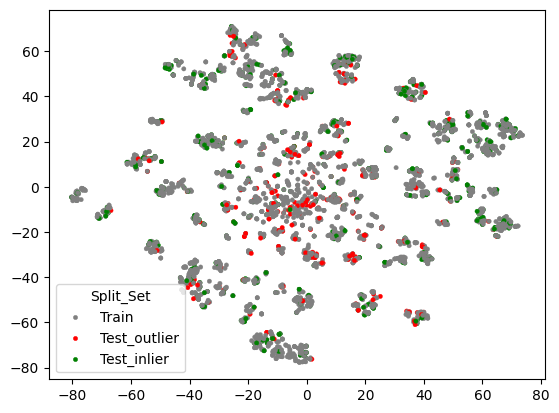

In [6]:
# make TSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
PC = tsne.fit_transform(dataset.getFeatures(concat=True, ordered=True))

# plot TSNE

# create new column with split information (train/test_inlier/test_outlier)
dataset.df["Split_Set"] = dataset.getDF()["Split_IsTrain"].map(
    {True: "Train", False: "Test_inlier"})
dataset.df.loc[dataset.getDF()["Split_IsOutlier"], "Split_Set"] = "Test_outlier"

import seaborn as sns

sns.scatterplot(x=PC[:, 0], y=PC[:, 1], hue=dataset.getDF()["Split_Set"],
                palette={"Train": "grey", "Test_inlier": "green",
                         "Test_outlier": "red"}, s=10, edgecolor=None)

# Determining applicability of new compounds

Moreover, the applicability domain specified in the dataset preparation can also be used to determine if new compounds are within the applicability domain of the model. If an applicability domain is attached to a dataset used for training a `QSPRModel`, it will be fitted on the whole dataset when the `fitAttached` method is called. The fitted applicability domain will then be attached to the model and when calling the `predictMols` method, it will return a dataframe with the predictions and a dataframe with information about whether the compounds are within the applicability domain of the model or not.

In [7]:
from qsprpred.models import SklearnModel
from sklearn.neighbors import KNeighborsRegressor

os.makedirs("../../tutorial_output/models", exist_ok=True)

# initialize model
model = SklearnModel(
    base_dir="../../tutorial_output/models",
    alg=KNeighborsRegressor,
    name="ApplicabilityDomainTutorialModel"
)

# We need to fit the model on the complete dataset to be able to use the attached applicability domain
_ = model.fitDataset(dataset)

qsprpred - WARNING - Random state supplied, but alg <class 'sklearn.neighbors._regression.KNeighborsRegressor'> does not support it. Ignoring this setting.


In [8]:
smiles_list = ["O=C(Nc1nc2ccccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1",
               "Nc1nc(-c2ccco2)c2ncn(C(=O)NCCc3ccccc3)c2n1",
               "CC(=O)NC1=CC=C(C=C1)O"]

model.predictMols(smiles_list, use_applicability_domain=True)

(array([[6.336],
        [8.325],
        [7.21 ]]),
 array([[ True],
        [ True],
        [False]]))